In [1]:
import numpy as np
from astropy.table import Table, Column, join
from astropy.coordinates import SkyCoord
from astropy.table import Column
from numpy import *
import matplotlib.pyplot as plt
%matplotlib inline
from astropy.wcs import WCS
from astropy.io import fits
from matplotlib.colors import LogNorm
from astropy.utils.data import download_file
import warnings
import os

warnings.filterwarnings('ignore')

homedir = os.getenv("HOME")
catalog_path='/Users/EvanB.LAPTOP-8CHCIOMA/Downloads/2024-04-25-20240907T013110Z-001/2024-04-25/'

In [2]:
#os.listdir(catalog_path)

In [3]:
%run ~/Downloads/readtablesv2.py --help

usage: readtablesv2.py [-h] [--tabledir TABLEDIR] [--tableprefix TABLEPREFIX]

Read in all virgo filament tables

options:
  -h, --help            show this help message and exit
  --tabledir TABLEDIR   directory where tables are stored
  --tableprefix TABLEPREFIX
                        prefix for tables; default is vf_v2


In [4]:
%run ~/Downloads/readtablesv2.py --tabledir $catalog_path

In [5]:
# Tables
myTab = v.main 
myTab2 =Table.read(catalog_path+'vf_v2_r_photometry.fits')

In [6]:
# Reads in Environment table that contains local density values
envTab=Table.read(catalog_path+'vf_v2_environment.fits')

In [7]:
#d = sorted(d, key=lambda x: x["first"]) # Sorts d from smallest to largest distance for each target point

### Cut Tables

In [8]:
# Catalog cuts from Castignani

# RA cut
raTab = myTab['RA']
ramax = 280
ramin = 100
raflag = (raTab>ramin) & (raTab<ramax)

# DEC cut
decTab = myTab['DEC']
decmin = -1.3
decmax = 75
decflag = (decTab>decmin) & (decTab<decmax)

# Magnitude cut
Mr = myTab2['M_r']
Mrmax = -15.7
Mrflag = (Mr <= Mrmax) #(Mr > Mrmin)

# Velocity cut
vr = myTab['vr']
vflag = (vr > 500) & (vr < 3300)

# SG cuts
sgx = envTab['SGX']
sgy = envTab['SGY']
sgz = envTab['SGZ']
xflag = (-13 < sgx) & (sgx < 20)
yflag = (2 < sgy) & (sgy < 38)
zflag = (-15 < sgz) & (sgz < 33)

cut = raflag & decflag & vflag & Mrflag & xflag & yflag & zflag

cuttab = myTab[cut]

# Applying same cuts to environment table
envcuttab = envTab[cut]

### Setup

In [9]:
ra = np.array(cuttab['RA']) # Right ascension of each galaxy
dec = np.array(cuttab['DEC']) # Declination of each galaxy
vpoints = np.array(cuttab['vr']) # Recessional velocity of each galaxy


# Set up array of galaxy locations
points = []
for i in range(len(dec)):
    points.append((ra[i],dec[i])) # Array of tuples of ra and dec (each galaxy now represented by a point)
        
n = len(points)

def distance(ra1, dec1, ra2, dec2):
    return np.sqrt(((ra1 - ra2))**2 + (dec1 - dec2)**2) # Distance between two points

def Five_Nearest(points, target, K, vtarg):
    pts = []
    d = []

    for i in range(1,n): 
        if (abs(vtarg - vpoints[i]) < 300): # Compares the velocity of each galaxy to the next and records it if it is within +/- 300 km/s
            d.append({
                "first": distance(points[i][0], points[i][1], target[0], target[1]), # Finds distance between target point and another point
                "second": i # Stores index number corresponding to the point that had its distance relative to the target found
            })
     
    d.sort(key=lambda x: x["first"]) # Sorts d from smallest to largest distance for each target point
 
    for i in range(K): # Loops through for however many times are specified by K (I will use K=6)
        pt = []
        pt.append(points[d[i]["second"]][0]) # First element of a tuple in an array of nearest points sorted by distance
        pt.append(points[d[i]["second"]][1]) # Second element of a tuple in an array of nearest points sorted by distance
        pts.append(pt) # Stores all individual pt values as tuples
 
    return pts # Returns the six nearest galaxies to a target galaxy (the first of which is the original target galaxy)

### Main Algorithm

In [10]:
def Local_Density(cuttab):

    # Find five nearest galaxies to each galaxy
    five_nn = [] # Store nearest neighbors
    vfnn = []

    K = 6 # Number of times to calculate nearest neighbors 
    for j in range(n):
        target = points[j] # Switches target point
        vtarg = cuttab['vr'][j]
        for pt in Five_Nearest(points, target, K, vtarg): # Calculates five nearest points for each galaxy in points and stores them along with their targets
            five_nn.append((pt[0], pt[1])) # Includes six points for each target, the first of which in each set is the target itself\

    # Separating target points from fifth nearest points
    target_fnn = np.array(points) # list of original target galaxies
    five_nn = np.array(five_nn)

    fifth_nn = np.array(five_nn[5::6]) # skips every six points starting with the sixth value so that all that is left is the fifth nearest point of each target

    # Finding angular distance
    dist_fifth_nn = []
    
    # Calculates angular distance between each galaxy and its fifth nearest meighbor
    for i in range(n):
        target0 = target_fnn[i] # Changes target on each loop through
        dist_fifth_nn.append(distance(fifth_nn[i][0], fifth_nn[i][1], target0[0], target0[1])) # Produces distance array

    # Finds velocities of fifth nearest neighbors
    v = []
    for i in range(len(fifth_nn)):
        for j in range(n): 
            if (fifth_nn[i][0] == points[j][0]) & (fifth_nn[i][1] == points[j][1]):
                v.append(cuttab['vr'][i]) #[j]

    # Convert angles in degrees to radians
    radians = (np.pi/180)*(np.array(dist_fifth_nn))

    # Finding distance, in Mpc, between the Sun and the galaxies
    H0 = 74 #km/s/Mpc
    d = (np.array(v))/H0 #Mpc np.array(v) np.array(cuttab['vr'])

    # Using small angle approximation to find distance between galaxies
    r_5 = d*radians #Mpc


    # Find fifth nearest neighbor density
    sigma_5 = 5/(np.pi*(r_5**2)) 
    
    return sigma_5

In [11]:
sigma_5 = Local_Density(cuttab)

In [12]:
max(sigma_5)

276.35482732074814

In [13]:
# Local densities
my_sigma_5 = sigma_5 # from my calculations
vfs_sigma_5 = envcuttab['n5th_2D'] # from vfs

In [14]:
max(vfs_sigma_5)

424.7573463013038

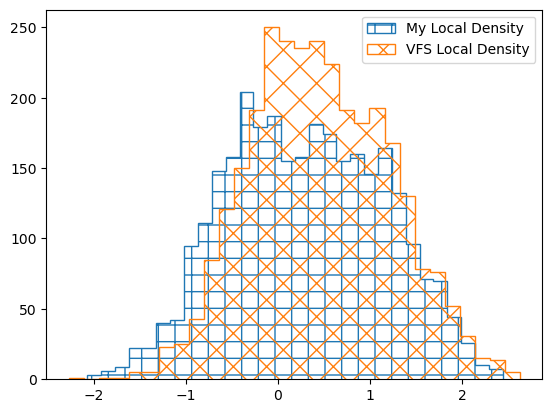

In [15]:
plt.hist(np.log10(my_sigma_5),label='My Local Density',histtype='step',bins=30,hatch='+')
plt.hist(np.log10(vfs_sigma_5),label='VFS Local Density',histtype='step',bins=30,hatch='x')

plt.legend()

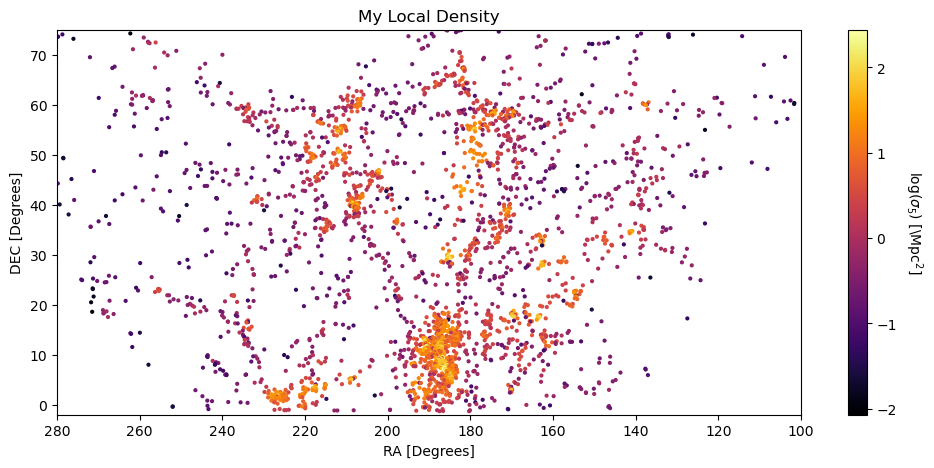

In [24]:
# My local density plot

ra1 = cuttab['RA']
dec1 = cuttab['DEC']
ccode1 = np.log10(my_sigma_5)

#Plot RA vs DEC and colored by local density
plt.figure(figsize=(12,5))
plt.scatter(ra1,dec1,c=ccode1,cmap='inferno',s=4)
plt.xlim(reversed(plt.xlim()))
plt.title('My Local Density')
plt.xlabel('RA [Degrees]')
plt.ylabel('DEC [Degrees]')
plt.xlim(280,100)
plt.ylim(-2,75)
cbar = plt.colorbar()
cbar.set_label('log($\sigma _5$) [\Mpc$^2$]',rotation=270,labelpad=20)

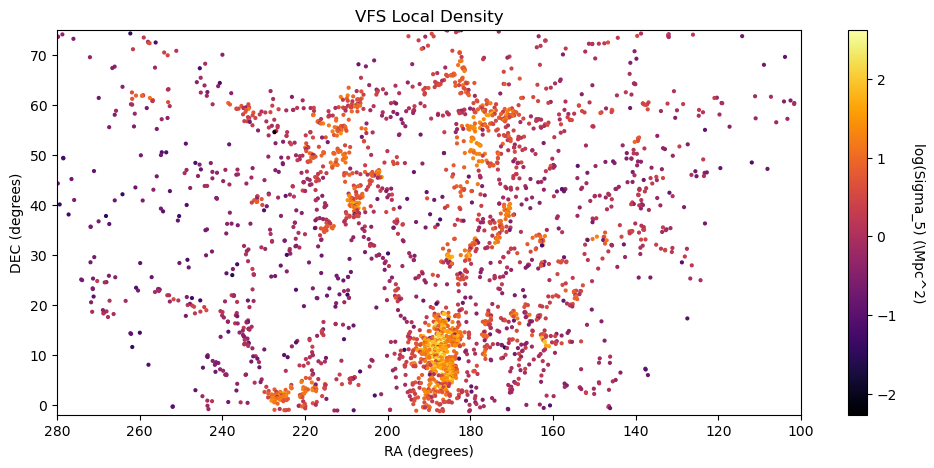

In [17]:
# VFS local density plot

ra2 = cuttab['RA']
dec2 = cuttab['DEC']
ccode2 = np.log10(vfs_sigma_5)

#Plot RA vs DEC and color it by recessional velocity
plt.figure(figsize=(12,5))
plt.scatter(ra2,dec2,c=ccode2,cmap='inferno',s=4) # ,alpha=0.8
plt.xlim(reversed(plt.xlim()))
plt.title('VFS Local Density')
plt.xlabel('RA (degrees)')
plt.ylabel('DEC (degrees)')
plt.xlim(280,100)
plt.ylim(-2,75)
cbar = plt.colorbar()
cbar.set_label('log(Sigma_5) (\Mpc^2)',rotation=270,labelpad=20)

In [18]:
print(median(my_sigma_5))
print(median(vfs_sigma_5))

1.9838858293568669
2.6628492113452085


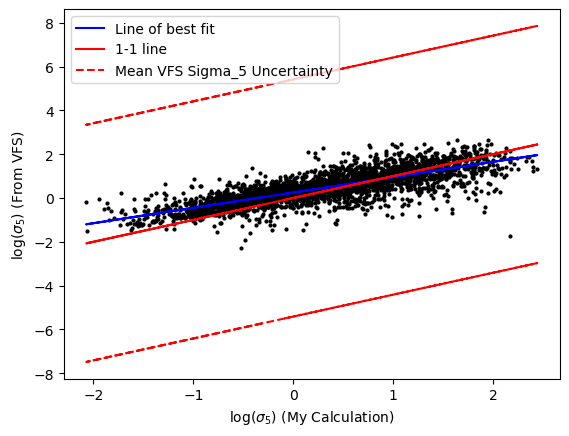

In [19]:
x1 = np.log10(my_sigma_5)
y1 = np.log10(vfs_sigma_5)
yerr = mean(envcuttab['n5th_2D_err'])

#calculate equation for trendline
z = np.polyfit(x1, x1, 1)
p = np.poly1d(z)

a, b = np.polyfit(x1, y1, 1)

line = np.array(p(x1))
plt.scatter(x1, y1, color='black', cmap='inferno', s=4) #, color='black'
plt.xlabel('log($\sigma _5$) (My Calculation)')
plt.ylabel('log($\sigma _5$) (From VFS)')


#add trendline to plot
plt.plot(x1, a*x1+b,color='b',label='Line of best fit')
plt.plot(x1,p(x1),color='r',label='1-1 line')
plt.plot(x1,p(x1-yerr), color='r',label='Mean VFS Sigma_5 Uncertainty',linestyle='dashed')
plt.plot(x1,p(x1+yerr), color='r',linestyle='dashed')
#plt.plot(x2,y2,color='r',label='1-1 line')
#plt.fill_between(x2, y2-error, y2+error)
plt.legend()
plt.show()